In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
import os
os.chdir('../')

In [9]:
import importlib

In [12]:
from  importlib import reload as rl
from Trees import DecisionTree
rl(Trees)

<module 'Trees' from 'E:\\Allen\\Project\\Learning\\scratch\\Trees\\__init__.py'>

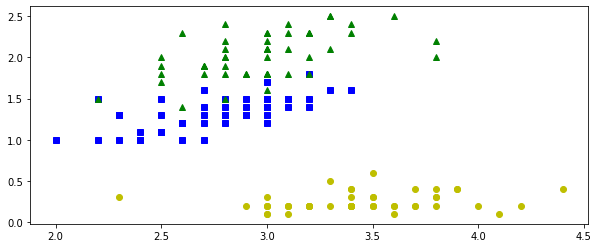

In [15]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, [1,3]] # petal length and width
y = iris.target
def plot_iris(X, y):
    fig = plt.figure(figsize=(10,4))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
    return fig

_ = plot_iris(X,y)

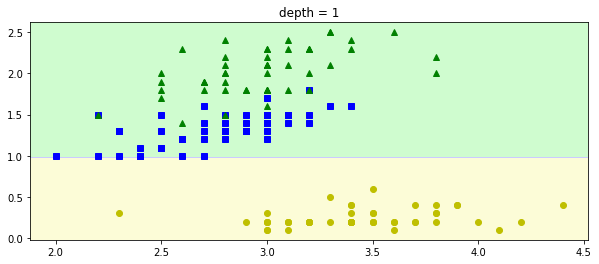

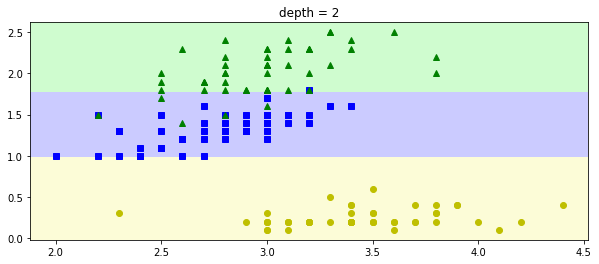

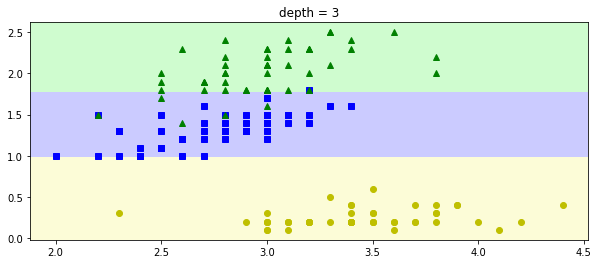

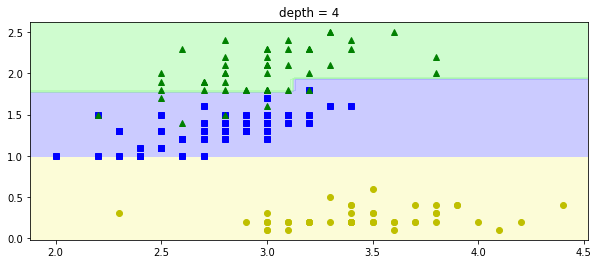

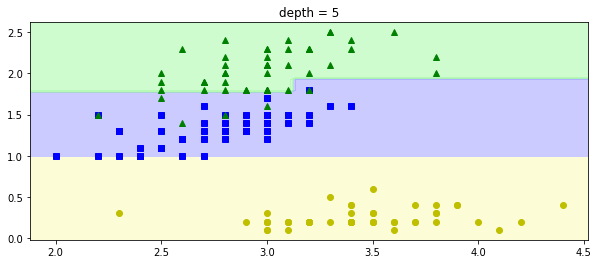

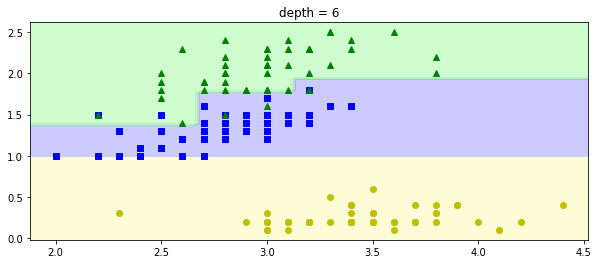

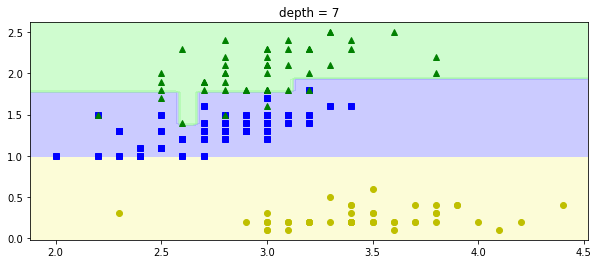

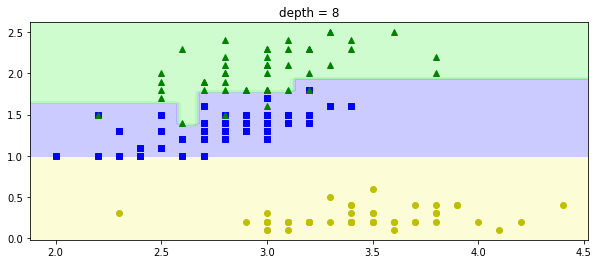

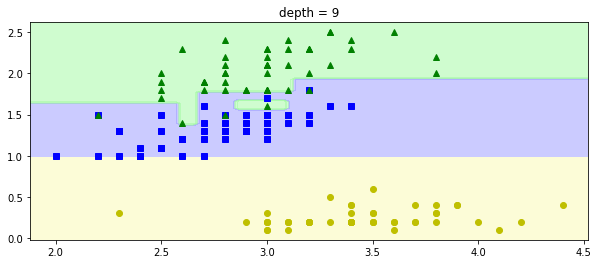

In [17]:
for depth in range(1,10):
    plot_iris(X,y)
    axes = plt.axis()
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    tree = DecisionTree.DecisionTree(max_depth=depth,random_state=1122)
    tree.fit(X,y)
    y_pred = np.array(tree.predict(X_new)).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap)
    plt.title('depth = {}'.format(depth))
    plt.show()

In [895]:
class Entropy():
    def __init__(self): pass
    
    def loss(self, y_hat):
        y_hat = np.array(y_hat)
        
        entropy = np.sum([
                -p*np.log2(p) for p in [
                    (y_hat==i).astype(np.int64).mean() for i in 
                        np.unique(y_hat)]
                    ])
        
        return entropy
    
    def gradient(self, y_hat):
        y_hat = np.array(y_hat)
        
        gradient = np.sum([
                (np.log(p)+1)/np.log(2) for p in [
                    (y_hat==i).astype(np.int64).mean() for i in 
                        np.unique(y_hat)]
                    ])
        
        return gradient
    
class Gini():
    def __init__(self): pass
    
    def loss(self, y_hat):
        y_hat = np.array(y_hat)
        
        entropy = np.sum([
                -np.log2(p) for p in [
                    (y_hat==i).astype(np.int64).mean() for i in 
                        np.unique(y_hat)]
                    ])
        
        return entropy
    
    def gradient(self, y_hat):
        y_hat = np.array(y_hat)
        
        gradient = np.sum([
                1/np.log(2) for p in [
                    (y_hat==i).astype(np.int64).mean() for i in 
                        np.unique(y_hat)]
                    ])
        
        return gradient
            

In [896]:
loss = Entropy()
loss.loss(y)
loss.gradient(y)

-0.42680237949657873

In [897]:
class exact_split_search():
    def __init__(self, X,y):
        self.X = X
        self.y = y
        self.m= X.shape[1]
        self.n=X.shape[0]
    def __iter__(self):
        self.feature_idx = 0
        self.threshold_idx = -1
        return self
    def __next__(self):
        self.X_candidate = np.unique(self.X[:,self.feature_idx])
        self.X_candidate_n = len(self.X_candidate)
        self.threshold_idx += 1
        if self.threshold_idx == self.X_candidate_n:
            self.threshold_idx =0
            self.feature_idx += 1
        if self.feature_idx == self.m:
            raise StopIteration
        return self.feature_idx , self.X_candidate[self.threshold_idx]        
    
class quantile_split_search():
    def __init__(self, X,y, n_proposal=20, random_state = None):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.n_proposal = n_proposal
        self.m= X.shape[1]
        self.n=X.shape[0]
        np.random.seed(random_state)
    def __iter__(self):
        self.feature_idx = 0
        self.threshold_idx = -1
        return self
    def __next__(self):
        self.X_candidate = np.linspace(self.X[:,self.feature_idx].min(),
                                      self.X[:,self.feature_idx].max(),self.n_proposal)
        np.random.shuffle(self.X_candidate)
        self.X_candidate_n = len(self.X_candidate)
        self.threshold_idx += 1
        if self.threshold_idx == self.X_candidate_n:
            self.threshold_idx =0
            self.feature_idx += 1
        if self.feature_idx == self.m:
            raise StopIteration
        return self.feature_idx , self.X_candidate[self.threshold_idx]        

In [914]:
class TreeNode():
    def __init__(self, feature_idx=None, threshold=None, depth=None,is_leaf=False):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.depth = depth
        self.left = None
        self.right = None
    
    def activate(self,X,y):
        
        if self.is_leaf:
            self.values, self.counts = np.unique(y,return_counts=True)
            return (None, None, None, None)
        
        X_left = X[X[:,self.feature_idx]< self.threshold]
        y_left = y[X[:,self.feature_idx]< self.threshold]
        X_right = X[X[:,self.feature_idx] >= self.threshold]
        y_right = y[X[:,self.feature_idx] >= self.threshold]
        
        return X_left, y_left, X_right, y_right
    
    def predict(self,x):
        if self.is_leaf:
            return self.values[self.counts.argmax()]
        else:
            if x[self.feature_idx] <= self.threshold:
                return self.left.predict(x)
            else:
                return self.right.predict(x)

    
class DecisionTree():
    """
    class Decision Tree
    
    Args:
    --------------------------------------
    
    """
    def __init__(self, criterion=None, splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0):
        self.criterion = criterion
        self.splitter = splitter,
        self.max_depth = max_depth
        self.min_sample_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        
    def _calculate_loss_decrease(self, y, y_left, y_right):
        loss = Entropy()
        gain = loss.loss(y)\
                -loss.loss(y_left)*len(y_left)/len(y)\
                -loss.loss(y_right)*len(y_right)/len(y)
        
        return gain
    
    def _best_splitter(self,X,y):
        score = 0
        splitter = dict(feature_idx=None,threshold=None)
        for feature_idx, threshold in quantile_split_search(X,y,random_state=self.random_state):
            
            score_new = self._calculate_loss_decrease(y, 
                                                 y[X[:,feature_idx]< threshold], 
                                                 y[X[:,feature_idx]>= threshold])
            if score < score_new:
                score = score_new
                splitter = dict(feature_idx=feature_idx,
                                threshold=threshold)
        
        return splitter, score
    
    def _tree_grow(self,node,X,y):
        
        X_left, y_left, X_right, y_right =  node.activate(X,y)
        
        if not node.is_leaf: 
            if node.depth == self.max_depth:
                is_leaf = True

            else:
                is_leaf = False

            left_spliter, score_left = self._best_splitter(X_left,y_left)
            is_leaf_left = is_leaf or len(np.unique(y_left)) == 1 or score_left ==0
            
            node.left = TreeNode(left_spliter['feature_idx'],
                                left_spliter['threshold'],
                                node.depth+1,
                                is_leaf_left)
            self._tree_grow(node.left, X_left,y_left)
            

            right_spliter, score_right = self._best_splitter(X_right, y_right)
            is_leaf_right = is_leaf or len(np.unique(y_right)) == 1 or score_right==0
            
            node.right = TreeNode(right_spliter['feature_idx'],
                                right_spliter['threshold'],
                                node.depth+1,
                                is_leaf_right)
            self._tree_grow(node.right, X_right, y_right)
    
    def fit(self, X, y):
        self.depth = 1
        splitter, score = self._best_splitter(X,y)
        self.Tree = TreeNode(splitter['feature_idx'],
                            splitter['threshold'],
                             1,
                            False)
        self._tree_grow(self.Tree, X,y)
        
    def _predict_i(self,x):
        return self.Tree.predict(x)
    
    def predict(self,X):
        return [self._predict_i(x) for x in X]
        

In [915]:
tree = DecisionTree(max_depth=10)

In [916]:
#tree = DecisionTreeClassifier(max_depth=100)
tree.fit(X,y)

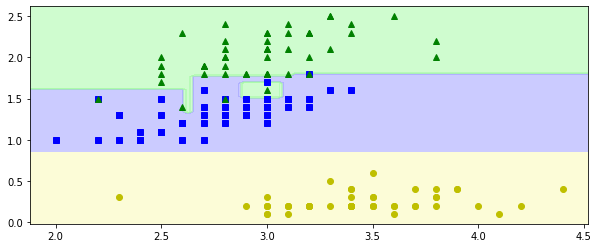

In [917]:
plot_iris(X,y)
axes = plt.axis()
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = np.array(tree.predict(X_new)).reshape(x1.shape)
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap)

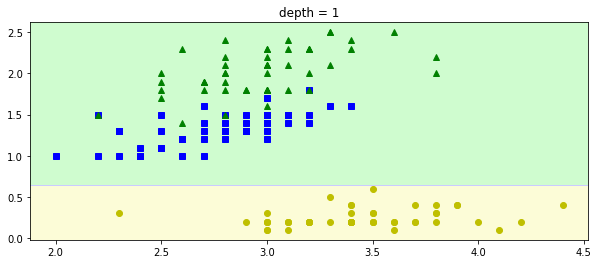

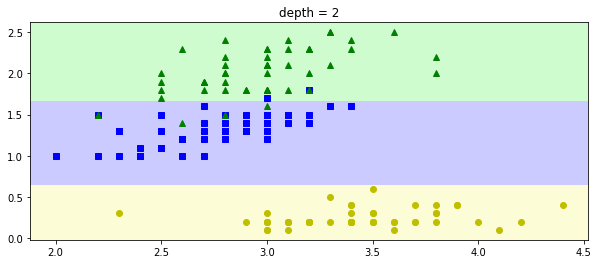

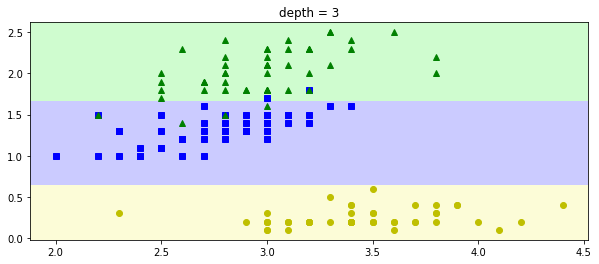

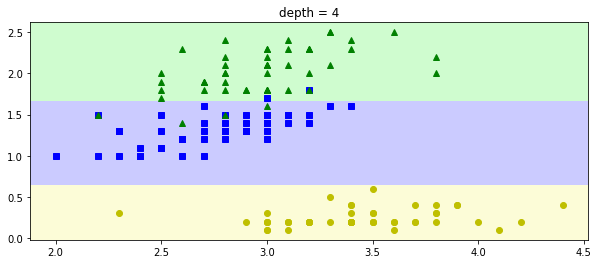

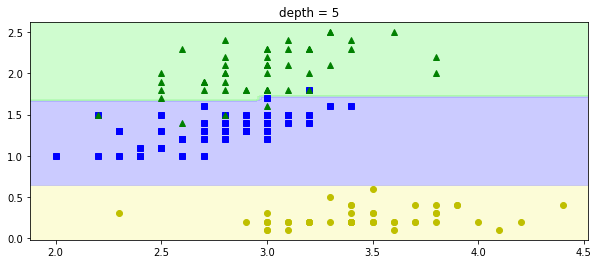

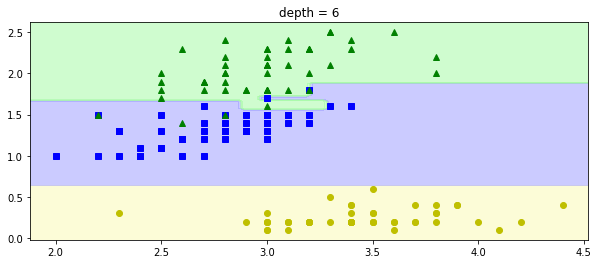

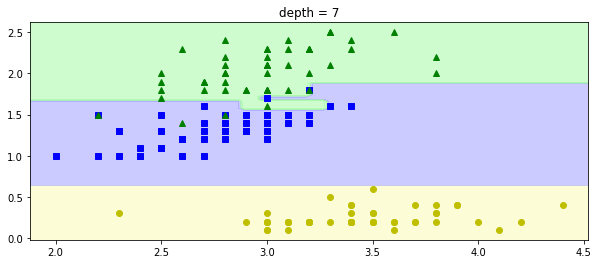

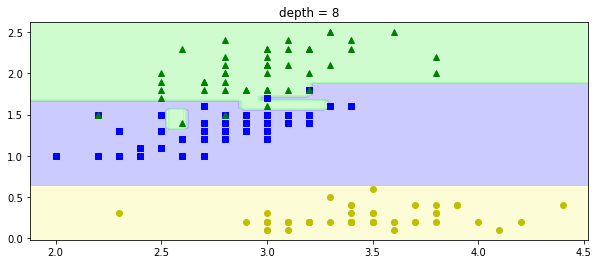

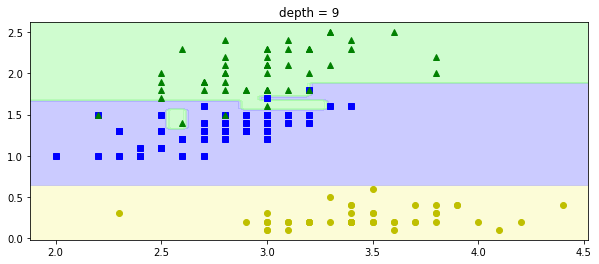

In [909]:
for depth in range(1,10):
    plot_iris(X,y)
    axes = plt.axis()
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    tree = DecisionTree(max_depth=depth,random_state=1122)
    tree.fit(X,y)
    y_pred = np.array(tree.predict(X_new)).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap)
    plt.title('depth = {}'.format(depth))
    plt.show()